In [1]:
from sklearn.preprocessing import (
    PolynomialFeatures,
    MinMaxScaler)
from sklearn.linear_model import (
    LinearRegression,
    Ridge,
    PoissonRegressor
    )
from sklearn.ensemble import (
    RandomForestRegressor
)
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [2]:
full_source,ysource = fetch_openml(data_id=43927,return_X_y=True,as_frame=True)

full_source['Price'] = ysource

full_source['DATE']=pd.to_datetime(
    full_source['month'].astype(int).astype(str)+"/"+
    full_source['day'].astype(int).astype(str)+"/"+
    full_source['year'].astype(int).astype(str)
)

full_source.sort_values(by='DATE',ascending=True,inplace=True)

c:\Users\Jason\Desktop\git_control\ml-research\.venv\Lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
mask = (full_source['region']=='WestTexNewMexico')&(full_source['type']=='organic')

In [4]:
source = full_source[mask].copy()

source.index = source['DATE'].values

In [7]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

def sinu_feat(x,period=1,freq=53,func='sin'):

    if func=='sin':
        f = np.sin
    else:
        f = np.cos

    return f(2*np.pi*period*x/freq)



In [8]:
train_split = .3

In [75]:

weeks = source['DATE'].dt.isocalendar().week
dates = source['DATE']

X = pd.DataFrame()
for f in ['sin','cos']:
    for p in []:
        X[f"SINU_{f.upper()}_{str(p)}"] = sinu_feat(weeks,period=p,freq=53,func=f)

X['PRICE'] = source['Price'].copy()
X['N'] = range(1,len(X)+1)


y = source['Total Volume'].copy()

Xtrain,Xtest,ytrain,ytest,dtrain,dtest = train_test_split(X,y,dates,
    test_size=train_split,random_state=42,shuffle=False)

weights = np.random.binomial(n=1,p=1,size=len(Xtrain))

change_points_N = 0

change_points=dtrain[[int(len(dtrain)*(i/(change_points_N+1))) for i in range(1,change_points_N+1)]]

for d in change_points:
    Xtrain[f'change_point_{d}']=np.where(dtrain>=d,1,0)
    Xtest[f'change_point_{d}']=np.where(dtest>=d,1,0)


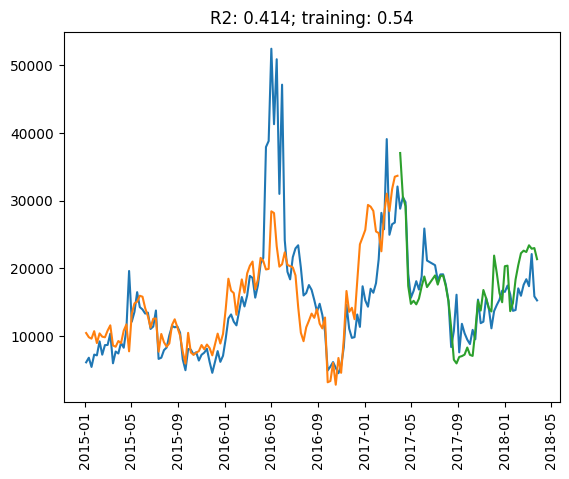

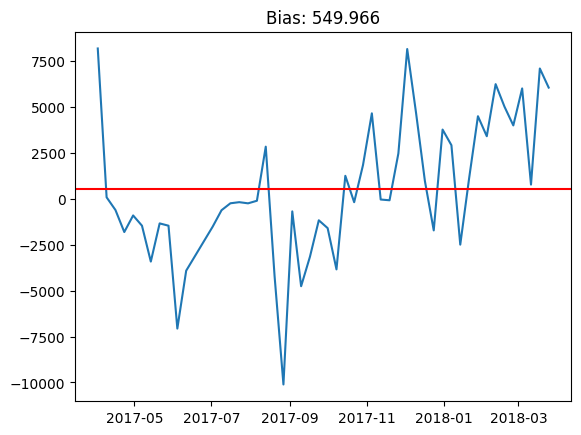

E(SE) = bias(ypred)**2 + var(ypred) + sig**2
E(SE) - bias(ypred)**2 = 14294212.814606413 = var(ypred) + sig**2
14596675.34854604 = 302462.53393962537 + 39286244.05132601 + -24992031.236719593


In [76]:

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=1,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain,learner__sample_weight=weights)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()


err = ypred - ytest
plt.plot(err)
plt.title(f"Bias: {round(sum(err)/len(err),3)}")
plt.axhline(y=np.mean(err),color='red')
plt.show()

MSE = sum((ypred-ytest)**2)/len(ypred)

bias = sum(ypred)/len(ypred) - sum(ytest)/len(ypred)
bias_squared = bias**2

var_plus_sig_squared = MSE - bias_squared

var = sum((ypred - np.mean(ypred))**2)/len(ypred)

sig_squared = MSE - bias_squared - var

print("E(SE) = bias(ypred)**2 + var(ypred) + sig**2")
print(f"E(SE) - bias(ypred)**2 = {var_plus_sig_squared} = var(ypred) + sig**2")
print(f"{MSE} = {bias_squared} + {var} + {sig_squared}")

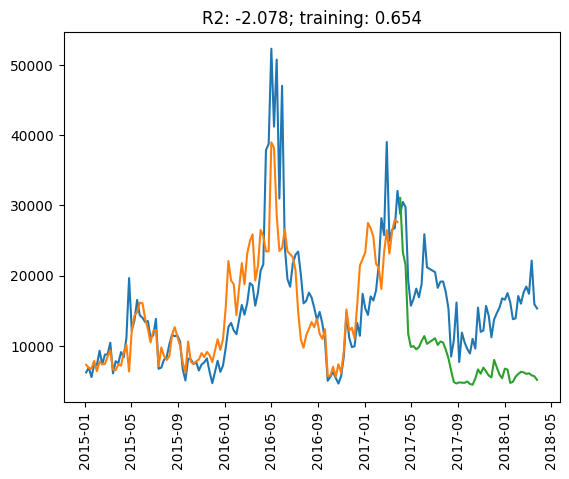

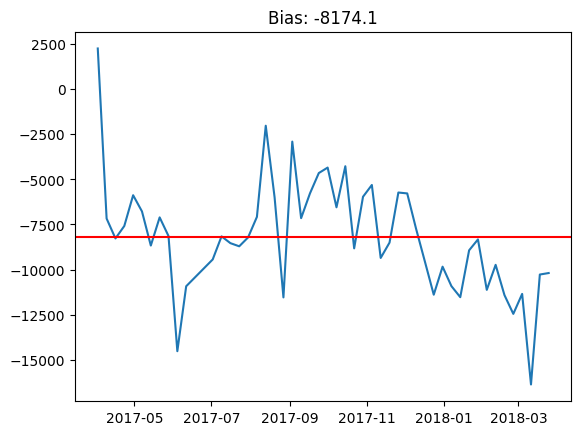

E(SE) = bias(ypred)**2 + var(ypred) + sig**2
E(SE) - bias(ypred)**2 = 9806614.562479764 = var(ypred) + sig**2
76622532.86070117 = 66815918.29822141 + 24540591.1456002 + -14733976.583120435


In [77]:

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=2,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain,learner__sample_weight=weights)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()


err = ypred - ytest
plt.plot(err)
plt.title(f"Bias: {round(sum(err)/len(err),3)}")
plt.axhline(y=np.mean(err),color='red')
plt.show()

MSE = sum((ypred-ytest)**2)/len(ypred)

bias = sum(ypred)/len(ypred) - sum(ytest)/len(ypred)
bias_squared = bias**2

var_plus_sig_squared = MSE - bias_squared

var = sum((ypred - np.mean(ypred))**2)/len(ypred)

sig_squared = MSE - bias_squared - var

print("E(SE) = bias(ypred)**2 + var(ypred) + sig**2")
print(f"E(SE) - bias(ypred)**2 = {var_plus_sig_squared} = var(ypred) + sig**2")
print(f"{MSE} = {bias_squared} + {var} + {sig_squared}")

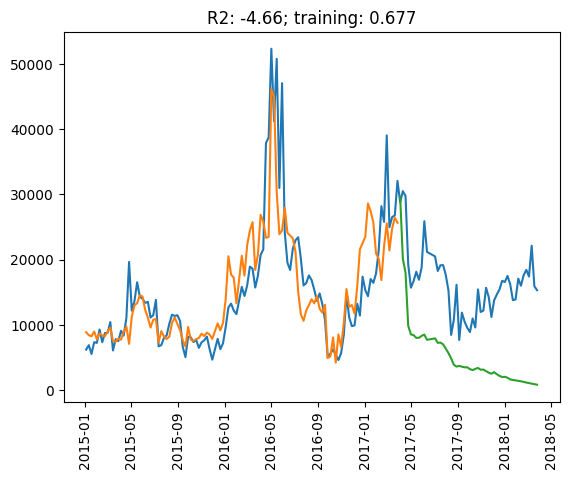

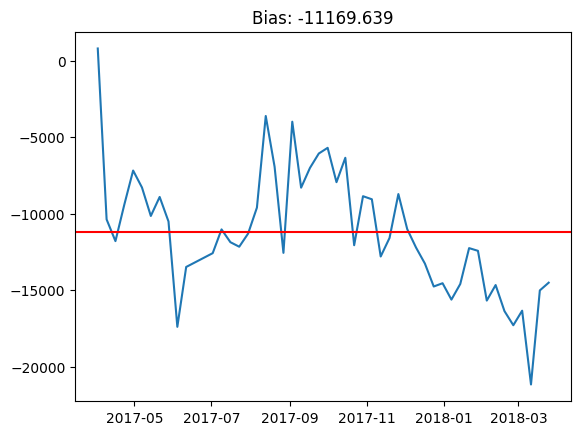

E(SE) = bias(ypred)**2 + var(ypred) + sig**2
E(SE) - bias(ypred)**2 = 16131108.990095973 = var(ypred) + sig**2
140891954.6674997 = 124760845.67740372 + 27543438.040640164 + -11412329.050544191


In [78]:

model = Pipeline(
    steps = [
        ('poly',PolynomialFeatures(degree=3,interaction_only=False)),
        ('scaler',MinMaxScaler()),
        ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
        #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
    ]
).fit(Xtrain,ytrain,learner__sample_weight=weights)

yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

plt.plot(y)
plt.plot(yfit)
plt.plot(ypred)
for d in change_points:
    plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
plt.xticks(rotation=90)
plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
plt.show()


err = ypred - ytest
plt.plot(err)
plt.title(f"Bias: {round(sum(err)/len(err),3)}")
plt.axhline(y=np.mean(err),color='red')
plt.show()

MSE = sum((ypred-ytest)**2)/len(ypred)

bias = sum(ypred)/len(ypred) - sum(ytest)/len(ypred)
bias_squared = bias**2

var_plus_sig_squared = MSE - bias_squared

var = sum((ypred - np.mean(ypred))**2)/len(ypred)

sig_squared = MSE - bias_squared - var

print("E(SE) = bias(ypred)**2 + var(ypred) + sig**2")
print(f"E(SE) - bias(ypred)**2 = {var_plus_sig_squared} = var(ypred) + sig**2")
print(f"{MSE} = {bias_squared} + {var} + {sig_squared}")

In [89]:

def make_model(power,plot=False,p=1):

    weights = np.random.binomial(n=1,p=p,size=len(Xtrain))

    model = Pipeline(
        steps = [
            ('poly',PolynomialFeatures(degree=power,interaction_only=False)),
            ('scaler',MinMaxScaler()),
            ('learner',PoissonRegressor(alpha=0,max_iter=10000,tol=1e-12)),
            #('learner',RandomForestRegressor(n_estimators=25,min_samples_leaf=5,random_state=42))
        ]
    ).fit(Xtrain,ytrain,learner__sample_weight=weights)

    yfit = pd.Series(model.predict(Xtrain),index = Xtrain.index)
    ypred = pd.Series(model.predict(Xtest),index = Xtest.index)

    if plot:
        plt.plot(y)
        plt.plot(yfit)
        plt.plot(ypred)
        for d in change_points:
            plt.axvline(x=d, color='r', linestyle='--', label='Vertical Line')
        plt.xticks(rotation=90)
        plt.title(f"R2: {round(r2_score(y_true=ytest,y_pred=ypred),3)}; training: {round(r2_score(y_true=ytrain,y_pred=yfit),3)}")
        plt.show()


    err = ypred - ytest
    
    if plot:
        plt.plot(err)
        plt.title(f"Bias: {round(sum(err)/len(err),3)}")
        plt.axhline(y=np.mean(err),color='red')
        plt.show()

    MSE = sum((ypred-ytest)**2)/len(ypred)

    bias = sum(ypred)/len(ypred) - sum(ytest)/len(ypred)
    bias_squared = bias**2

    var_plus_sig_squared = MSE - bias_squared

    var = sum((ypred - np.mean(ypred))**2)/len(ypred)

    sig_squared = MSE - bias_squared - var

    nfeats = len(model['learner'].coef_)+1

    return MSE,bias_squared,var_plus_sig_squared,nfeats


mse_list = []
bs_list = []
vpss_list = []
nfeats_list = []
for p in [1,2,3]:
    MSE,bias_squared,var_plus_sig_squared,nfeats = make_model(power=p,plot=False)
    mse_list.append(MSE)
    bs_list.append(bias_squared)
    vpss_list.append(var_plus_sig_squared)
    nfeats_list.append(nfeats)
    

In [90]:
nfeats_list

[4, 7, 11]

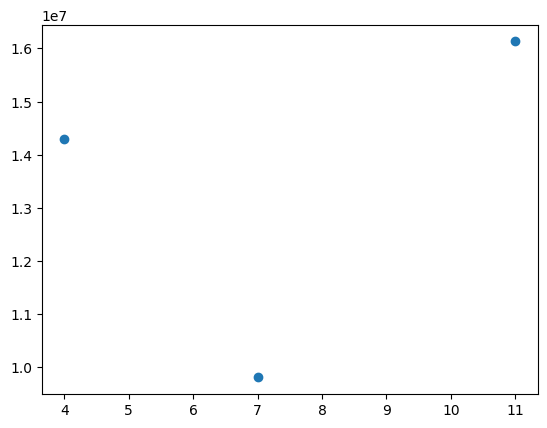

In [91]:
plt.scatter(nfeats_list,vpss_list)

In [100]:


outputs = []
for p in range(40):
    MSE,bias_squared,var_plus_sig_squared,nfeats = make_model(power=1,plot=False,p=.8)
    outputs.append([MSE,bias_squared,var_plus_sig_squared])

In [101]:
outputs_df = pd.DataFrame(outputs
                          ,
                          columns=['MSE','BIAS**2','VAR+SIG**2'])

In [102]:
outputs_df

,MSE,BIAS**2,VAR+SIG**2
0,1.447351e+07,7.376480e+03,1.446613e+07
1,1.282923e+07,1.219622e+03,1.282801e+07
2,1.571501e+07,1.065076e+06,1.464994e+07
3,1.462047e+07,2.601058e+02,1.462021e+07
4,1.395209e+07,2.726325e+05,1.367946e+07
5,1.351897e+07,2.532767e+05,1.326569e+07
6,1.335242e+07,1.590167e+05,1.319340e+07
7,1.431867e+07,4.503908e+05,1.386828e+07
8,2.021066e+07,2.515225e+06,1.769543e+07
9,1.272999e+07,4.048410e+04,1.268951e+07


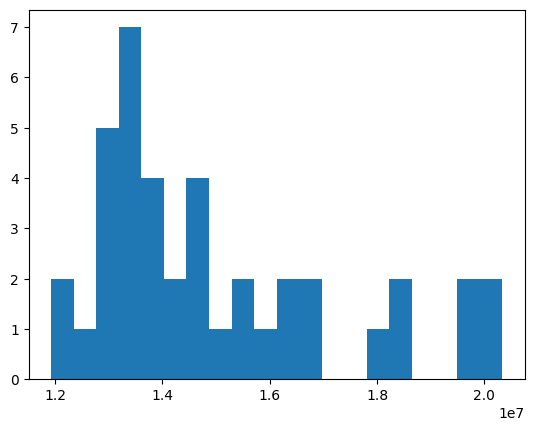

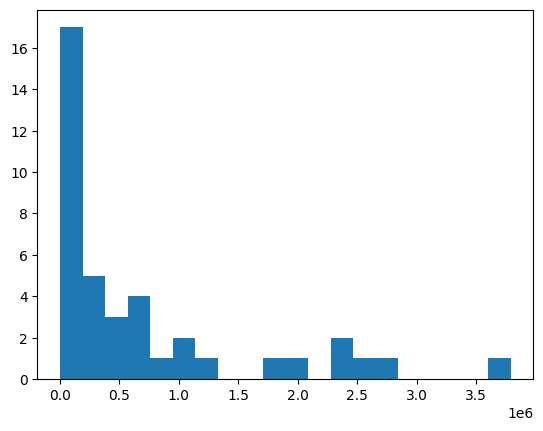

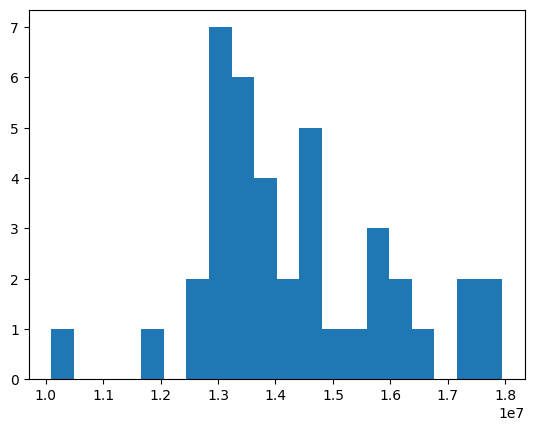

In [106]:
plt.hist(outputs_df['MSE'],bins=20)
plt.show()
plt.hist(outputs_df['BIAS**2'],bins=20)
plt.show()
plt.hist(outputs_df['VAR+SIG**2'],bins=20)
plt.show()
